In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme


from config import CONFIG
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
%matplotlib notebook
import math
import numpy as np
import pandas as pd
import sys
import statistics
import time
import scipy.optimize as spo

In [16]:
# uncomment and execute line to try a new theme
set_nb_theme('onedork')
# set_nb_theme('chesterish')
# set_nb_theme('grade3')
# set_nb_theme('oceans16')
# set_nb_theme('solarizedl')
# set_nb_theme('solarizedd')
# set_nb_theme('monokai')

In [3]:
path = CONFIG['PATH']
pairs = CONFIG['PAIRS']
start_date='2017-01-01'
end_date='2017-12-31'
dates=pd.date_range(start_date, end_date)
merged_candlesticks=pd.DataFrame(index=dates)

for pair in pairs:
    candlesticks = pd.read_csv(path + "/data/"+ pair.replace('/','-') +"/candlesticks.csv", parse_dates=True, usecols=['date','close'], na_values=['nan'])
    candlesticks['date'] = pd.Series([dt.datetime.fromtimestamp(int(ts)).strftime('%Y-%m-%d')
                                     for ts in candlesticks['date']]).values
    candlesticks = candlesticks.set_index('date')
    candlesticks = candlesticks.rename(columns={'close':pair})
    merged_candlesticks=merged_candlesticks.join(candlesticks)
    merged_candlesticks.dropna()
#print(merged_candlesticks.head(5)) 

In [4]:
def plot_data(df, title="Prices"):
    ax = df.plot(title=title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()

def normalize_data(df):
    return df / df.iloc[0,:]

def compute_daily_returns(df):
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:] / df[:-1].values) - 1
    daily_returns.iloc[0,:] = 0
    return daily_returns

def scatter_plot(df, base_pair):
    for pair in pairs:
        if pair != base_pair:
            df.plot(kind='scatter', x=base_pair, y=pair)
            beta, alpha = np.polyfit(daily_returns[base_pair], daily_returns[pair],1)
            plt.title("Beta and Alpha for " + pair + " in relation to " + base_pair)
            plt.plot(df[base_pair], beta * df[base_pair] + alpha, '-', color='r')
            print('alpha',alpha)
            print('beta',beta)

In [5]:
#print(merged_candlesticks.loc['2017-01-01':'2017-12-31', ['BTS/BTC','STEEM/BTC']].head(5))

# Daily Returns

<IPython.core.display.Javascript object>


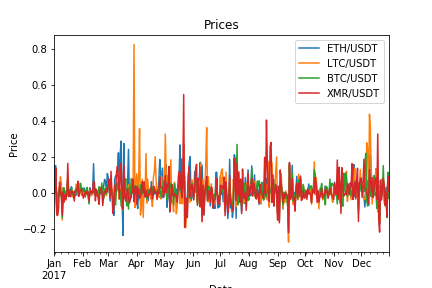

In [6]:
daily_returns=compute_daily_returns(merged_candlesticks)
plot_data(daily_returns)

# Plot Distribution of Daily Returns

<IPython.core.display.Javascript object>


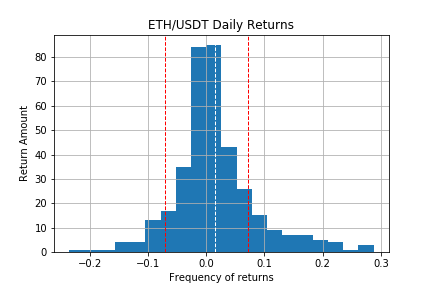

<IPython.core.display.Javascript object>


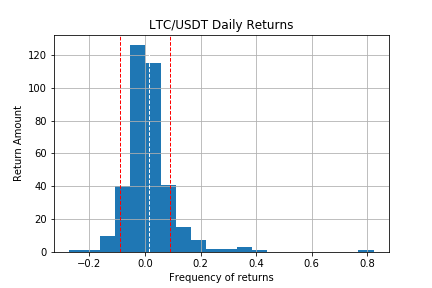

<IPython.core.display.Javascript object>


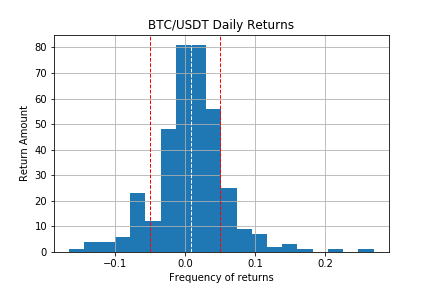

<IPython.core.display.Javascript object>


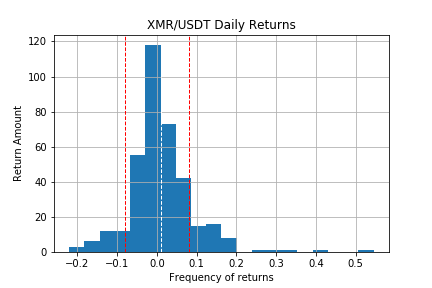

In [7]:
for pair in pairs:
    fig, ax = plt.subplots()
    daily_returns[pair].hist(bins=20, label=pair)
    mean = daily_returns[pair].mean()
    std = daily_returns[pair].std()
    ax.set_xlabel("Frequency of returns")
    ax.set_ylabel("Return Amount")
    ax.set_title(pair + " Daily Returns")
    plt.axvline(mean,color='w',linestyle='dashed', linewidth=1)
    plt.axvline(std,color='r',linestyle='dashed', linewidth=1)
    plt.axvline(-std,color='r',linestyle='dashed', linewidth=1)
plt.show()    

# Daily Return Beta & Alpha

* Alpha - pos = return is higher than asset it is compared to
* Beta - How reactive the market is

<IPython.core.display.Javascript object>


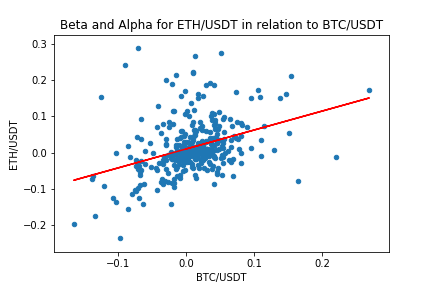

alpha 0.0105154994262
beta 0.52084419666


<IPython.core.display.Javascript object>


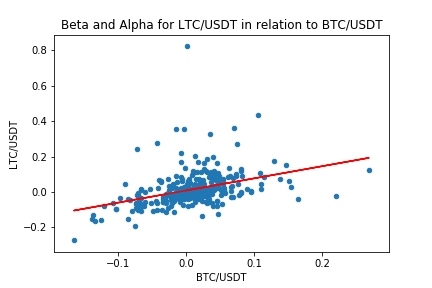

alpha 0.00854269620237
beta 0.685859215143


<IPython.core.display.Javascript object>


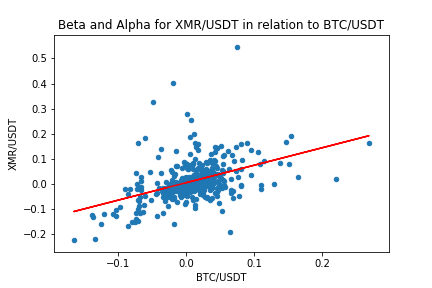

alpha 0.00558254748818
beta 0.695044172201


In [8]:
scatter_plot(daily_returns, 'BTC/USDT')

# Correlation Coef

In [9]:
print(daily_returns.corr(method='pearson'))

          ETH/USDT  LTC/USDT  BTC/USDT  XMR/USDT
ETH/USDT  1.000000  0.347535  0.367542  0.486397
LTC/USDT  0.347535  1.000000  0.382820  0.356871
BTC/USDT  0.367542  0.382820  1.000000  0.437815
XMR/USDT  0.486397  0.356871  0.437815  1.000000


# Normalize data

<IPython.core.display.Javascript object>


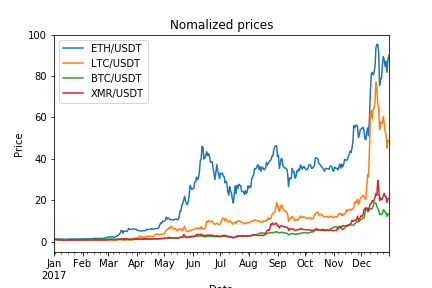

In [10]:
normalized=normalize_data(merged_candlesticks)
plot_data(normalized, "Nomalized prices")

# Daily Portfolio Values

* fetch prices
* normalize data
* multiply nomalized data by allocation amounts
* multiply allocated amounts by your initail portfolio start val (using 10 in this example)
* sum all columns


In [11]:
allocs = []
start_val = 100000

for pair in pairs:
    allocs.append(pairs[pair])

allocated = normalized * allocs
pos_vals = allocated * start_val
port_val = pos_vals.sum(axis=1)

In [12]:
daily_rf = 0

daily_returns = daily_returns[1:]
cum_ret=(port_val[-1]/port_val[0])-1
avg_daily_ret = daily_returns.mean()
std_daily_ret = daily_returns.std()
sharp_ratio = np.mean(daily_returns - daily_rf)/np.std(daily_returns)
sharp_ratio_annualized = math.sqrt(365)*sharp_ratio
sharp_ratio_annualized

ETH/USDT    3.982082
LTC/USDT    3.022562
BTC/USDT    3.162978
XMR/USDT    2.720902
dtype: float64

In [13]:
# window = 20
# no_of_std = 2

# rm_btc = pd.Series(candlesticks['close']).rolling(window=window).mean()
# rstd_btc = pd.Series(candlesticks['close']).rolling(window=window).std()
# candlesticks['Rolling Mean'] = rm_btc
# candlesticks['Rolling Mean'].fillna(method='bfill', inplace=True)


# candlesticks['Bollinger High'] = rm_btc + (rstd_btc * no_of_std)
# candlesticks['Bollinger High'].fillna(method='bfill', inplace=True)

# candlesticks['Bollinger Low'] = rm_btc - (rstd_btc * no_of_std)
# candlesticks['Bollinger Low'].fillna(method='bfill', inplace=True)

# x = candlesticks['date']
# ax = candlesticks[['close','Rolling Mean', 'Bollinger High', 'Bollinger Low']].plot(x, title="BTC/ETC Bollinger Bands", label="BTC/ETC")

# ax.set_xlabel("Date")
# ax.set_ylabel("Price")
# ax.legend(loc='upper left')

# Minimizer

In [14]:
def f(X):
    """ Given a scalar X, return some value (a real number) """
    Y = (X - 1.5)**2 + 0.5
    print("X = {}, Y = {}".format(X,Y)) # for tracing
    return Y

def test_run_minimizer():
    Xguess = 2.0
    min_result = spo.minimize(f, Xguess, method='SLSQP', options={'disp':True})
    print("X = {}, Y = {}".format(min_result,min_result.fun)) # for tracin
    
test_run_minimizer()

X = [ 2.], Y = [ 0.75]
X = [ 2.], Y = [ 0.75]
X = [ 2.00000001], Y = [ 0.75000001]
X = [ 0.99999999], Y = [ 0.75000001]
X = [ 1.5], Y = [ 0.5]
X = [ 1.5], Y = [ 0.5]
X = [ 1.50000001], Y = [ 0.5]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5
            Iterations: 2
            Function evaluations: 7
            Gradient evaluations: 2
X =      fun: 0.5
     jac: array([  1.49011612e-08])
 message: 'Optimization terminated successfully.'
    nfev: 7
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 1.5]), Y = 0.5


In [17]:
def error(lin, data):
    """Compute error between given line model and observed data
    
    Parameters
    line : tuble/list/array (C0, C1) where C0 is slope and C1 is Y-intercept
    data: 2D array where each row is a point (x,y)
    
    """
    
    err = np.sum((data[:, 1] - (line[0] * data[:, 0 ] + line[1])) ** 2)
    return err

def test_run_error():
    l_orig = np.float32([4,2])
    print("original line : C0 = {}, C1 = {}".format(l_orig[0], l_orig[1]))
    Xorig = np.linspace(0,10,21)
    Yorig = l_orig[0] * Xorig + l_orig[1]
    plt.plot(Xorig, Yorig, 'b--', linewidth=2.0, label="Original Line")
    
    # Generate Noisy data points
    noise_sigma = 3.0
    noise = np.random.normal(0, noise_sigma, Yorig.shape)
    data = np.asarray([Xorig, Yorig + noise]).T
    plt.plot(data[:,0], data[:,1], 'go', label="Data points")
    
        
def fit_line(data, error_func):
    """Fit a line to given data, using a supplied error function 
    
    Parameters
    
    data: 2D array where each row is a point (X0, Y)
    error_func: function that computes the error between a line and observed data
    
    Returns a line that minimizes the error function.
    
    """
    
    l = np.float32([0, np.mean(data[:, 1])]) # slope = 0, intercept = mean(y values)
    x_ends = np.float32([-5,5])
    plt.plot(x_ends, l[0] * x_ends + l[1], 'm--', linewidth=2.0, label="Initial guess")
    
    result = spo.minimize(error_func, l, args=(data,), method='SLSQP', options={'disp':True})
    return result.x

def error_poly(C, data):
    """Compute error between given polynomial and observed data
    
    Parameters
    
    C: numpy.poly1d object or equivalent array representing ploynomial coefficients
    data: 2D array where each row is a point (x,y)
    
    Returns error as a single real value

    """
    
    err = np.sum((data[:, 1] - np.polyval(C, data[:, 0]) ** 2))
    
def fit_poly(data, error_func, degree=3):
    """Fit a polynomial to a given data, using supplied error function
    
    Parameters
    
    data: data: 2D array where each row is a point (X, Y)
    error_func: function that computes the error between a polynomial and observed data

    """
    # Generate initial guess for polynomial model (all coeffs = 1)
    Cguess = np.poly1d(np.ones(degree + 1, dtype=np.float32))
    
    # plot initial guesss (optional)
    x = np.linspace(-5,5,21)
    plt.plot(x, np.polyval(Cguess,x), 'm--', linewidth=2.0, label="initial guess")
    
    # Call optimizer to minimize error function
    result = spo.minimize(error_func, Cguess, args(data,), method='SLSQP', options={'disp':True})
    return np.poly1d(result.x) # convert optimal result into a poly1d object
    
    
test_run_error()

original line : C0 = 4.0, C1 = 2.0
